In [1]:
import pyhf
import numpy as np
import matplotlib.pyplot as plt
from pyhf.contrib.viz import brazil

import ROOT
from ROOT import TGraph,TCanvas,TLegend

Welcome to JupyROOT 6.26/00


In [2]:
def F_GetHistograms(File,fix=""):
    Histograms = {}
    fn = ROOT.TFile.Open(File)
    for e in fn.GetListOfKeys(): 
        h = fn.Get(e.GetName())
        h.SetName(e.GetName()+fix)
        Histograms[h.GetName()] = h
        h.SetDirectory(0)
    fn.Close()
    return Histograms

def plotUpperLimits(labels,values,limits,XaxisTitle,YaxisTitle,theoryprediction = None,logy=False):
    # see CMS plot guidelines: https://ghm.web.cern.ch/ghm/plots/
 
    N = len(labels)
    yellow = TGraph(2*N)    # yellow band
    green = TGraph(2*N)     # green band
    median = TGraph(N)      # median line
    if theoryprediction:
        theory = TGraph(N)      # theory line
 
    up2s = [ ]
    dn2s = [ ]
    for i in range(N):
        limit = limits[i]
        up2s.append(limit[4])
        dn2s.append(limit[0])
        yellow.SetPoint(    i,    values[i], limit[4] ) # + 2 sigma
        green.SetPoint(     i,    values[i], limit[3] ) # + 1 sigma
        median.SetPoint(    i,    values[i], limit[2] ) # median
        if theoryprediction:
            theory.SetPoint(    i,    values[i], theoryprediction[i] ) # median
        green.SetPoint(  2*N-1-i, values[i], limit[1] ) # - 1 sigma
        yellow.SetPoint( 2*N-1-i, values[i], limit[0] ) # - 2 sigma
 
    W = 800
    H  = 800
    T = 0.08*H
    B = 0.12*H
    L = 0.12*W
    R = 0.04*W
    c = TCanvas("c","c",100,100,W,H)
    c.SetFillColor(0)
    c.SetBorderMode(0)
    c.SetFrameFillStyle(0)
    c.SetFrameBorderMode(0)
    c.SetLeftMargin( L/W )
    c.SetRightMargin( R/W )
    c.SetTopMargin( T/H )
    c.SetBottomMargin( B/H )
    c.SetTickx(0)
    c.SetTicky(0)
    c.SetGrid()
    if logy:
        c.SetLogy()
    c.cd()
    frame = c.DrawFrame(1.4,0.001, 4.1, 10)
    frame.GetYaxis().CenterTitle()
    frame.GetYaxis().SetTitleSize(0.05)
    frame.GetXaxis().SetTitleSize(0.05)
    frame.GetXaxis().SetLabelSize(0.03)
    frame.GetYaxis().SetLabelSize(0.03)
    frame.GetYaxis().SetTitleOffset(1.2)
    frame.GetXaxis().SetNdivisions(508)
    frame.GetYaxis().CenterTitle(True)
    frame.GetYaxis().SetTitle(YaxisTitle)
#    frame.GetYaxis().SetTitle("95% upper limit on #sigma #times BR / (#sigma #times BR)_{SM}")
    frame.GetXaxis().SetTitle(XaxisTitle)
    if logy:
        frame.SetMinimum(min(dn2s)*0.8)
        frame.SetMaximum(max(up2s)*2)
    else:
        frame.SetMinimum(0)
        frame.SetMaximum(max(up2s)*1.2)
    frame.GetXaxis().SetLimits(min(values),max(values))
 
    yellow.SetFillColor(ROOT.kOrange)
    yellow.SetLineColor(ROOT.kOrange)
    yellow.SetFillStyle(1001)
    yellow.Draw('F')
 
    green.SetFillColor(ROOT.kGreen+1)
    green.SetLineColor(ROOT.kGreen+1)
    green.SetFillStyle(1001)
    green.Draw('Fsame')
 
    median.SetLineColor(1)
    median.SetLineWidth(2)
    median.SetLineStyle(2)
    median.Draw('Lsame')

    theory.SetLineColor(2)
    theory.SetLineWidth(2)
    theory.SetLineStyle(1)
    theory.Draw('Lsame')
 
#     CMS_lumi.CMS_lumi(c,14,11)
    ROOT.gPad.SetTicks(1,1)
    frame.Draw('sameaxis')
 
    x1 = 0.45
    x2 = x1 + 0.24
    y2 = 0.9
    y1 = 0.75
    legend = TLegend(x1,y1,x2,y2)
    legend.SetFillStyle(0)
    legend.SetBorderSize(0)
    legend.SetTextSize(0.03)
    legend.SetTextFont(42)
    legend.AddEntry(median, "Asymptotic CL_{s} expected",'L')
    legend.AddEntry(green, "#pm 1 std. deviation",'f')
#    legend.AddEntry(green, "Asymptotic CL_{s} #pm 1 std. deviation",'f')
    legend.AddEntry(yellow,"#pm 2 std. deviation",'f')
    legend.AddEntry(theory, "theory prediciotn",'L')
#    legend.AddEntry(green, "Asymptotic CL_{s} #pm 2 std. deviation",'f')
    legend.Draw()
 
    Graphs = [yellow,median,green,]
    if theoryprediction:
        Graphs = [yellow,median,green,theory,legend]

    return c,Graphs

import multiprocessing 


def F_Limit(signal,bkg,bkg_uncertainty,observations,poiup,signalname,return_dict={}):
    pyhf.set_backend("numpy")
    model = pyhf.simplemodels.uncorrelated_background(
        signal=signal, bkg=bkg, bkg_uncertainty=bkg_uncertainty
    )
    observations = observations
    data = pyhf.tensorlib.astensor(observations + model.config.auxdata)
    poi_values = np.linspace(0, poiup, 41)
    obs_limit, exp_limits, (scan, results) = pyhf.infer.intervals.upper_limits.upper_limit(
        data, model, poi_values, return_results=True
    )

    print(f"{signalname}:Upper limit (obs): μ = {obs_limit:.4f}")
    print(f"{signalname}:Upper limit (exp): μ = {exp_limits[2]:.4f}")
    return_dict[signalname]=exp_limits
    
    return poi_values,results,exp_limits

def F_MultiProcess(Func,args,processnumber = 80):
    manager = multiprocessing.Manager()
    return_dict = manager.dict() # in order to check if the ifile is run successfully
    pool  = multiprocessing.Pool(processes = processnumber)
    for arg in args:
        pool.apply_async(Func,(*arg,return_dict))
    pool.close()
    pool.join()
    return return_dict



# simple example

Upper limit (obs): μ = 0.9423
Upper limit (exp): μ = 0.9423


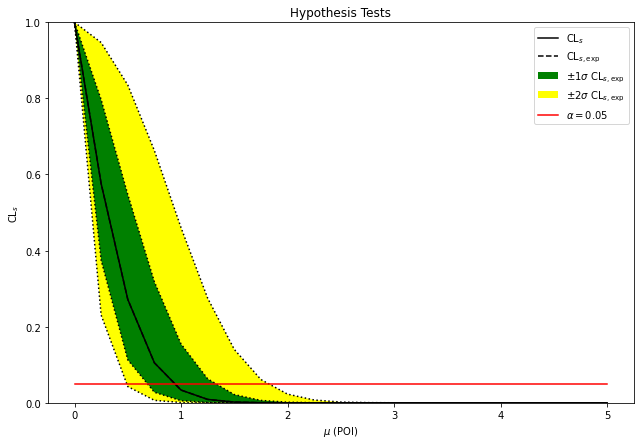

In [3]:
pyhf.set_backend("numpy")
model = pyhf.simplemodels.uncorrelated_background(
    signal=[12.0, 11.0], bkg=[50.0, 52.0], bkg_uncertainty=[.3, .5]
)
observations = [50, 52]
data = pyhf.tensorlib.astensor(observations + model.config.auxdata)
poi_values = np.linspace(0, 5, 21)
obs_limit, exp_limits, (scan, results) = pyhf.infer.intervals.upper_limits.upper_limit(
    data, model, poi_values, return_results=True
)

print(f"Upper limit (obs): μ = {obs_limit:.4f}")
print(f"Upper limit (exp): μ = {exp_limits[2]:.4f}")

fig, ax = plt.subplots()
fig.set_size_inches(10.5, 7)
ax.set_title("Hypothesis Tests")


artists = brazil.plot_results(poi_values, results, ax=ax)

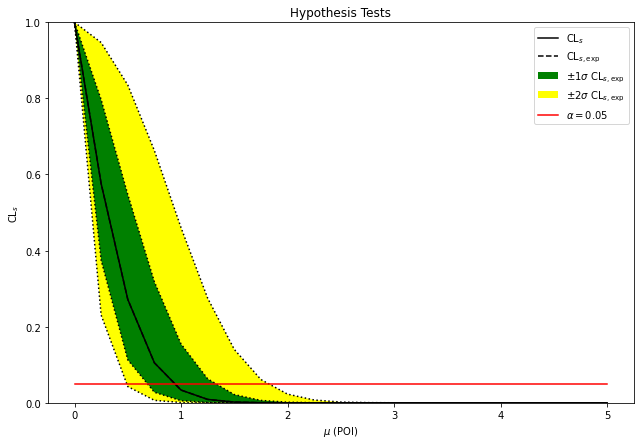

In [4]:
fig, ax = plt.subplots()
fig.set_size_inches(10.5, 7)
ax.set_title("Hypothesis Tests")


artists = brazil.plot_results(poi_values, results, ax=ax)

# complex model

histosys

lumi

normfactor

normsys

shapefactor

shapesys

staterror

In [5]:
model_json = {
    "channels": [
        { "name": "SR_combined",
          "samples": [
            { "name": "signal",
              "data": [4,9],
              "modifiers": [ { "name": "mu", "type": "normfactor", "data": None},
                              {"name": "uncorr_siguncrt", "type": "shapesys", "data": [2.1,1.1]},
              ]
            },
            { "name": "background",
              "data": [1,0.5],
              "modifiers": [
                            {"name": "uncorr_bkguncrt", "type": "normsys", "data": {"hi": 1.8, "lo": 0.5}},
                             {"name": "mod_name", "type": "histosys", "data": {"hi_data": [20,15], "lo_data": [10, 10]}} 
                           ]
            }
          ]
        }
    ],
    "observations": [
        { "name": "SR_combined", "data": [0.9,0.4] }
    ],
    "measurements": [
        { "name": "Measurement", "config": {"poi": "mu", "parameters": []} }
    ],
    "version": "1.0.0"
}


Upper limit (obs): μ = 0.2863
Upper limit (exp): μ = 0.2911


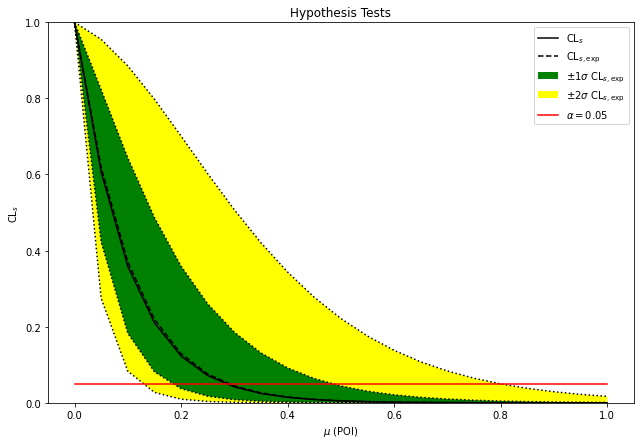

In [6]:
ws = pyhf.Workspace(model_json)
model = ws.model()
data = ws.data(model)

poi_values = np.linspace(0, 1, 21)
obs_limit, exp_limits, (scan, results) = pyhf.infer.intervals.upper_limits.upper_limit(
    data, model, poi_values, return_results=True
)

print(f"Upper limit (obs): μ = {obs_limit:.4f}")
print(f"Upper limit (exp): μ = {exp_limits[2]:.4f}")

fig, ax = plt.subplots()
fig.set_size_inches(10.5, 7)
ax.set_title("Hypothesis Tests")

artists = brazil.plot_results(poi_values, results, ax=ax)

# Draw limit

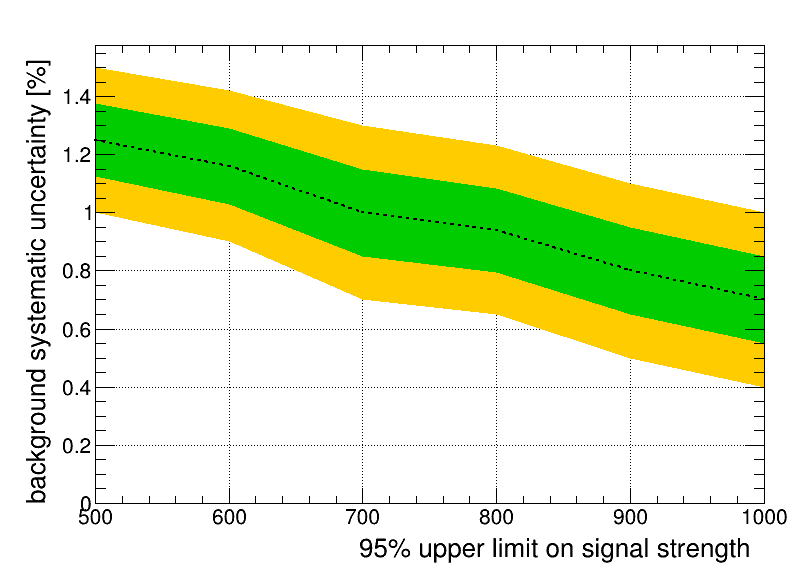

In [7]:
labels = [1,2,3,4,5,6]

values = [500,600,700,800,900,1000]
limits = [
    np.linspace(1., 1.5, 5),
    np.linspace(0.9, 1.42, 5),
    np.linspace(0.7, 1.3, 5),
    np.linspace(0.65, 1.23, 5),
    np.linspace(0.5, 1.1, 5),
    np.linspace(0.4, 1., 5),
    
]

# c,_ = plotUpperLimits(labels,values,limits,"95% upper limit on #sigma / #sigma_{SM}","background systematic uncertainty [%]")
c,_ = plotUpperLimits(labels,values,limits,"95% upper limit on signal strength","background systematic uncertainty [%]")
c.Draw()

# default target lumi is 0.9 ab-1

In [3]:
%%time
# Histograms_Input = F_GetHistograms("/data/pubfs/guoql/plots/4321Model/PS5/V4/M/Allsignal/MVLL1_all.root")
# Histograms_Input = F_GetHistograms("/data/pubfs/guoql/plots/4321Model/PS5/V7/Mreg/Allsignal/MVLL_DNN_ReluSimple_V9_all.root")
Histograms_Input = F_GetHistograms("/data/pubfs/guoql/plots/4321Model/PS5/V7/M/Allsignal/MVLL_DNN_ReluSimple_V9_all.root")
# Histograms_Input = F_GetHistograms("/data/pubfs/guoql/plots/4321Model/PS/V8/M/Allsignal/MVLL1_all.root")

Histograms = {}
# signals = [ i for i in range(500,1550,50) if i not in [550,650,1350,1400,1450]]
signals = [ i for i in range(500,1550,50)]
TotalMC = None
for index,name in enumerate(Histograms_Input):
    if ("EE" not in name) & ("NN" not in name):
        if not TotalMC:
            TotalMC = Histograms_Input[name].Clone("TotalMC")
        else:
            TotalMC.Add(Histograms_Input[name])

Limits = {}
        
Scale = 0.01
# Scale = 0.07
poiup = 3
MutiArgs = []

TotalMC.Scale(Scale)
TotalMC.SetBinErrorOption(ROOT.TH1D.kPoisson)
bkg = [TotalMC.GetBinContent(i+1) for i in range(TotalMC.GetNbinsX())]
bkg_uncertainty = [TotalMC.GetBinError(i+1) for i in range(TotalMC.GetNbinsX())]
observations = bkg
for Signal in signals:
    name = "EE_%s_origin"%(Signal)
    Histograms_Input[name].Scale(Scale)
    signal = [Histograms_Input[name].GetBinContent(i+1) for i in range(Histograms_Input[name].GetNbinsX())]
#     poi_values,results,exp_limits = F_Limit(signal,bkg,bkg_uncertainty,observations,poiup=2,signalname=Signal,)
#     Limits[Signal] = exp_limits
    MutiArgs.append((
        signal,bkg,bkg_uncertainty,observations,poiup,Signal
    ))
    
#     fig, ax = plt.subplots()
#     fig.set_size_inches(10.5, 7)
#     ax.set_title("Hypothesis Tests")
#     artists = brazil.plot_results(poi_values, results, ax=ax)
#     break

Limits = F_MultiProcess(F_Limit,MutiArgs,processnumber = 80)

800:Upper limit (obs): μ = 0.2485
800:Upper limit (exp): μ = 0.2485
1350:Upper limit (obs): μ = 0.3855
1350:Upper limit (exp): μ = 0.3855
950:Upper limit (obs): μ = 0.2486
950:Upper limit (exp): μ = 0.2486
900:Upper limit (obs): μ = 0.2544
900:Upper limit (exp): μ = 0.2544
550:Upper limit (obs): μ = 0.2926
550:Upper limit (exp): μ = 0.2926
850:Upper limit (obs): μ = 0.2473
850:Upper limit (exp): μ = 0.2473
1400:Upper limit (obs): μ = 0.4898
1400:Upper limit (exp): μ = 0.4898
1250:Upper limit (obs): μ = 0.3171
1250:Upper limit (exp): μ = 0.3171
1300:Upper limit (obs): μ = 0.3483
1300:Upper limit (exp): μ = 0.3483
500:Upper limit (obs): μ = 0.3277
500:Upper limit (exp): μ = 0.3277
1150:Upper limit (obs): μ = 0.2843
1150:Upper limit (exp): μ = 0.2843
1450:Upper limit (obs): μ = 0.6438
1450:Upper limit (exp): μ = 0.6438
1000:Upper limit (obs): μ = 0.2581
1000:Upper limit (exp): μ = 0.2581
1200:Upper limit (obs): μ = 0.2934
1200:Upper limit (exp): μ = 0.2934
1050:Upper limit (obs): μ = 0.27

In [30]:
for i in Limits:
    print(Limits[i],i)

[array(3.), array(3.), array(3.), array(3.), array(3.)] 1500
[array(0.99017695), array(1.75193393), array(3.), array(3.), array(3.)] 1300
[array(1.11162128), array(1.96656151), array(3.), array(3.), array(3.)] 1350
[array(0.80548031), array(1.42310475), array(2.70678928), array(3.), array(3.)] 1150
[array(0.90123552), array(1.59598342), array(3.), array(3.), array(3.)] 1250
[array(0.69198571), array(1.22178944), array(2.32021829), array(3.), array(3.)] 800
[array(0.72015632), array(1.2706656), array(2.41599644), array(3.), array(3.)] 1000
[array(0.83918296), array(1.48428652), array(2.82253909), array(3.), array(3.)] 1200
[array(0.69438111), array(1.22669525), array(2.33037734), array(3.), array(3.)] 950
[array(0.76658768), array(1.35462326), array(2.57641592), array(3.), array(3.)] 1050
[array(0.71375197), array(1.2583276), array(2.3893085), array(3.), array(3.)] 700
[array(0.79008907), array(1.39598259), array(2.65360145), array(3.), array(3.)] 1100
[array(0.68796994), array(1.215128

In [4]:
import yaml
def read_yaml_to_dict(yaml_path: str, ):
    with open(yaml_path) as file:
        dict_value = yaml.load(file.read(), Loader=yaml.FullLoader)
    if not dict_value:
        dict_value = {}
    return dict_value

def save_dict_to_yaml(dict_value: dict, save_path: str):
    with open(save_path, 'w') as file:
#         file.write(yaml.dump(dict_value, allow_unicode=True))
        file.write(yaml.dump(dict_value, allow_unicode=False))

Samples = read_yaml_to_dict("/home/pku/guoql/4321Model/Plot/V1/SamplesPlot3TeV_Sep.yaml")

In [5]:
import re
import numpy
def ReadXS(Files):
    XSs = []
    for ifile in Files:
        with open(ifile) as f:
            content = f.read()
        search = re.compile(r'Cross-section :(\s){1,} (.*) \+\- (.*) pb')
        if search.search(content):
            XS = search.search(content).group(2)
            XSs.append(float(XS))
    return numpy.mean(XSs)

import glob
XSs = {}
for i in ["EE","NN"]:
    for signal in signals:
        Files = glob.glob("/data/bond/lyazj/vll/%s/mumu%s3D/mumu%s-*/runmg5-*.log"%(signal,i,i))
        XS = ReadXS(Files)
        XSs[(i,signal)] = XS
Samples_new = Samples
for i in XSs:
    j = "%s_%s"%(i[0],str(int(i[1])))
    Samples_new[j]["XS"] = float(XSs[i])
save_dict_to_yaml(Samples_new,"Samples.yaml")

In [5]:
XSs = {}
samples = ["tth","wwh","zzh","bbh","zhh","tatah"]
for sample in samples:
    Files = glob.glob("/data/bond/lyazj/vll/bg/mumu%s3D/mumu%s-*/runmg5-*.log"%(sample,sample))
    XS = ReadXS(Files)
    XSs[(sample)] = XS

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


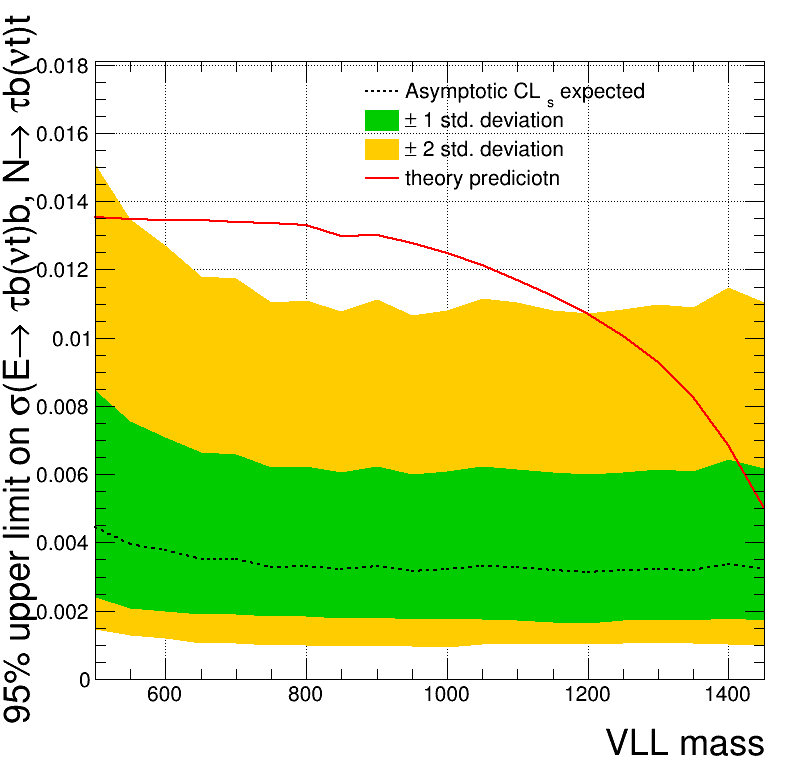

In [9]:
labels = []
values = []
limits = []
theory = []
for i in signals:
    XS = Samples['EE_%s'%(str(i))]['XS']+Samples['NN_%s'%(str(i))]['XS']
#     print(XS)
    if i == 1500: 
        continue
    values.append(i)
    theory.append(XS)
    limit = [x*XS for x in Limits[i]]
#     print(limit)
    limits.append(limit)
    labels.append(i)

c,_ = plotUpperLimits(labels,values,limits,"VLL mass","95% upper limit on #sigma(E#rightarrow #taub(#nut)b, N#rightarrow #taub(#nut)t",theory,logy=False)

c.Draw()